# Residual neural networks

## Objectives:
- implementing a residual layer 
- using batchnormalization layers 
- observing the effects on the gradients at initialization of residual layers, batchnormalization layers and the depth of neural networks.
- observing the effects on overfitting of residual layers, batchnormalization layers and the depth of neural networks. 

## Contents

1. Implementing a Residual Network  
2. Observing vanishing, shattering and exploding gradients
3. Effects of residual layers, batchnormalization and depth on overfitting   


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

torch.manual_seed(123)

## 1. Implementing a Residual Network

#### TODO

1. Define a class ``MyResidualLayer`` implementing a residual layer, taking as parameter ``n_hid`` and ``use_skip`` such that:
- ``out = x + relu(fc(x))`` if ``use_skip = True``
- ``out = relu(fc(x))`` if ``use_skip = False``

where ``fc`` is a fully connected layer with as many inputs as outputs ``n_hid``.

2. Define a class ``MyNet``, implementing a neural network with ``L`` (blocks of) trainable layers such that:
- The first layer is a fully connected layer with ``n_in=1`` inputs and ``n_hid`` outputs
- The next ``L-2`` layers are residual layers (defined using ``MyResidualLayer``) with ``n_hid`` hidden units or fully connected depending on the value of a boolean parameter ``use_skip``. You can set ``n_hid`` to ``128`` for example.
- The last layer is a fully connected layer with ``n_hid`` inputs and ``n_out=1`` outputs. 
- Every ``batchnorm_frequency`` layers, a batchnorm layer is inserted. 


In [2]:
class MyResidualLayer(nn.Module):
    def __init__(self, n_hid, use_skip=True):
        super().__init__()
        self.use_skip = use_skip
        self.fc = nn.Linear(n_hid, n_hid)
        
    def forward(self, x):
        residual = x
        if self.use_skip:
            out = residual + F.relu(self.fc(x))
        else: 
            out = F.relu(self.fc(x))
        return out
    
class MyNet(nn.Module):
    def __init__(self, n_in=1, n_hid=128, n_out=1, L=10, batchnorm_frequency=None, use_skip=True):
        super().__init__()
        
        # For residual skip
        self.use_skip = use_skip
        self.layer1 = nn.Linear(n_in, n_hid)
        
        # With batchnorm
        if batchnorm_frequency is not None:
            module_list = []
            for i in range(2, L):
                module_list.append(MyResidualLayer(n_hid, use_skip=use_skip))
                # Batchnorm not necessarily after each layer
                if i % batchnorm_frequency == 0:
                    module_list.append(nn.BatchNorm1d(n_hid))
                    
        # Without batchnorm
        else: 
            module_list = [MyResidualLayer(n_hid, use_skip=use_skip) for _ in range(L-2)]
            
        self.layer_block = nn.ModuleList(module_list)
        self.layerL = nn.Linear(n_hid, n_out)
        
    def forward(self, x):
        out = F.relu(self.layer1(torch.flatten(x, 1)))
        for layer in self.layer_block:
            out = layer(out)
        out = self.layerL(out)
        return out

## 2. Observing vanishing, shattering and exploding gradients

### Computing gradients with respect to the input 


Rather than computing the gradients with respect to the network's parameters as you are now used to, we will instead compute the gradients with respect to the input data. This is meaningful since by the chain rule, the derivatives with respect to inputs are connected to the derivatives with respect to parameters. Since we are interested in observing how network depth impacts the gradients, we will use a simple grid of uniformly spaced data points ranging from -3 to 3 as input for our network.

#### TODO

1. Write a function that computes the mean gradient values with respect to an input ``X`` consisting of 256 points uniformly spaced between ``[-3,3]`` for ``n_iter = 30`` random model initializations of your ``MyNet`` model. To do so:
1. Seeds pytorch, 
1. Repeat:
    1. Instanciante a ``MyNet`` model. (You might need to add parameters to your function so that you can instanciate your model with different values of ``batchnorm_frequency``, ``use_skip``, etc.)
    1. Emulate the beginning of a training phase by calling ``train_one_epoch``
    1. Disable autograd for all the network's parameters. Enable autograd for an uniformly spaced input ``X``.
    1. Perform a forward pass with ``X`` as input.
    1. Run a backward pass on the output. (You might need to sum all the components of the output before calling ``backward()``)
    1. Store the gradient with respect to the input ``X``. You might need to use .clone() and/or .detach() methods.
1. For each element of ``X`` compute the mean gradient value obtained with the different model initialization.
1. Return the mean gradient values.   

In [3]:
def train_one_epoch(model):
    """
    Performs one small training iteration to emulate an early training situation
    """
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=1e-1)
    loss_fn = nn.MSELoss()
    optimizer.zero_grad(set_to_none=True)
    
    X = torch.linspace(-3, 3, 10).unsqueeze(1)  

    outputs = model(X)
    loss = loss_fn(outputs, torch.cos(X))
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()


def compute_gradients(model, X):
    """
    Compute gradients with respect to input
    """
    gradients = []
    model.train()
    model.requires_grad_(False)
    
    X.requires_grad_(True)
    outputs = model(X)
    outputs.sum().backward()
    gradients = X.grad.data.clone()
    X.grad.zero_()
    X.requires_grad_(False)
            
    return gradients


def compute_mean_gradients(X, L, use_skip=True, batchnorm_frequency=None, n_iter=30):
    """
    Compute mean gradient with respect to input for n_iter random initializations
    """
    torch.manual_seed(265)
    list_gradients = []
    for _ in range(n_iter):
        model = MyNet(
            L = L,
            batchnorm_frequency = batchnorm_frequency,
            use_skip = use_skip,
        )
        train_one_epoch(model)
        list_gradients.append(compute_gradients(model, X).unsqueeze(0))
    return torch.cat(list_gradients).mean(0)

def plot_gradients(ax, L, X, gradients):
    """
    Plot mean gradient with respect to input for n_iter random initializations
    """
    ax.set_title('Number of layers:' + str(L))
    ax.plot(X, gradients)
    ax.set_xlabel('X')
    ax.set_ylabel('Gradient')
    return ax


### Experiment

#### TODO

1. Plot mean gradient values with respect to the input ``X`` for different values of depth, ``batchnorm_frequency`` and with or without residual skip (``use_skip`` set to ``True`` or ``False``). You can keep the values suggested in the cell below.
1. Comment your results. 
1. Do you observe shattering gradients? If so, in which conditions?  
1. Do you observe vanishing gradients? If so, in which conditions? 
1. Do you observe exploding gradients? If so, in which conditions? 

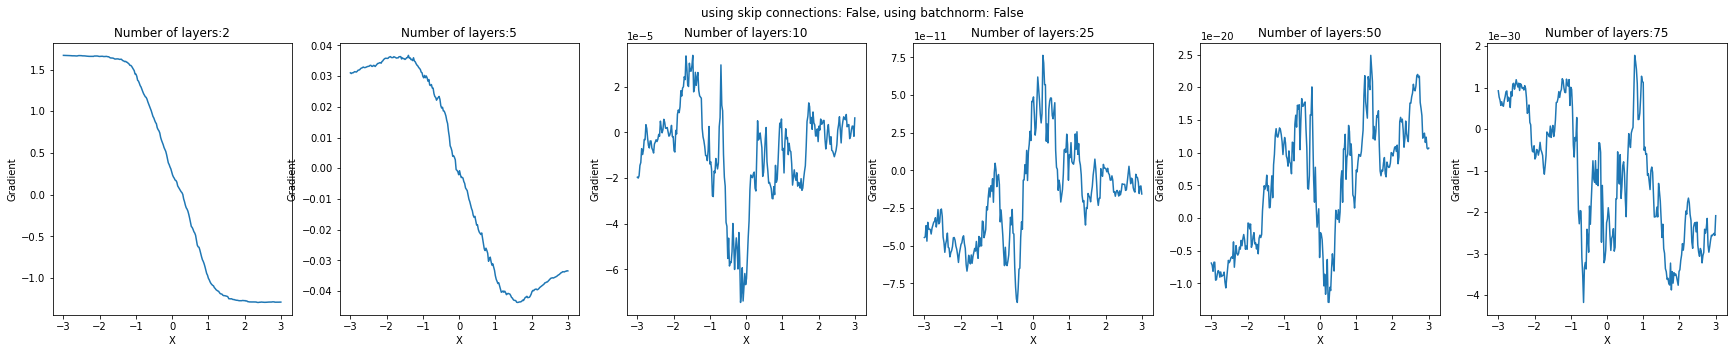

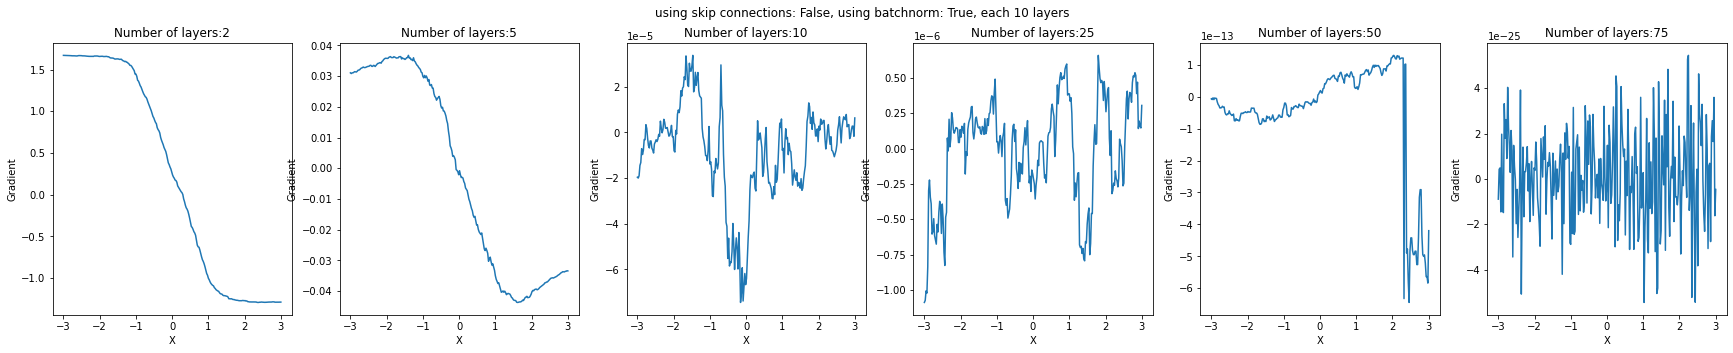

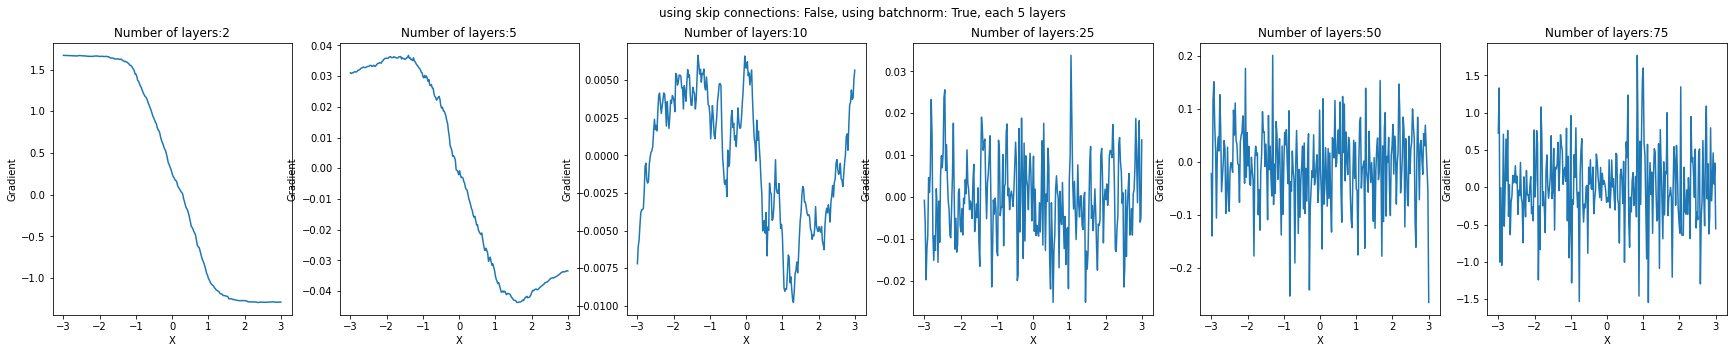

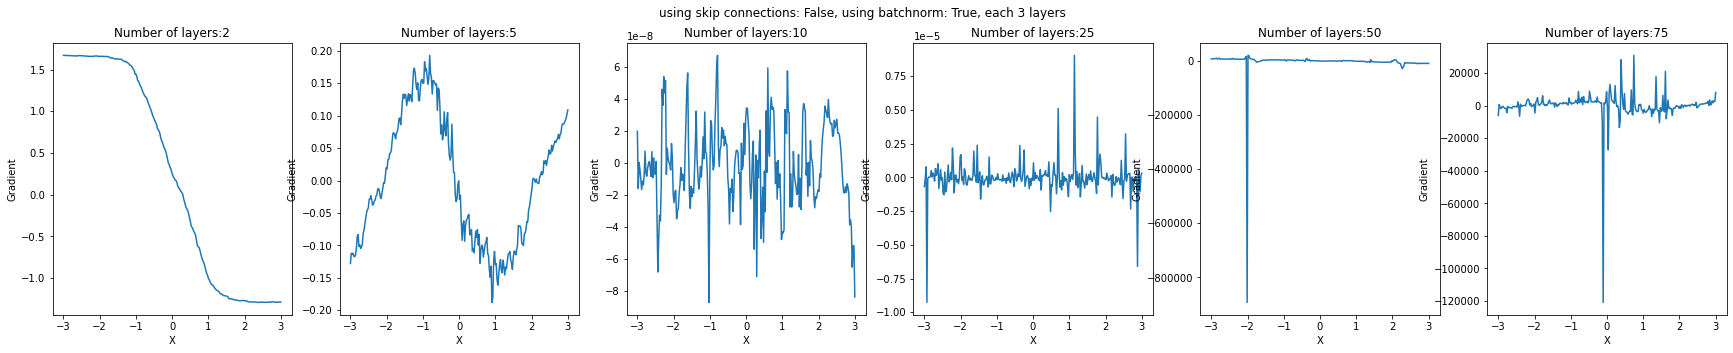

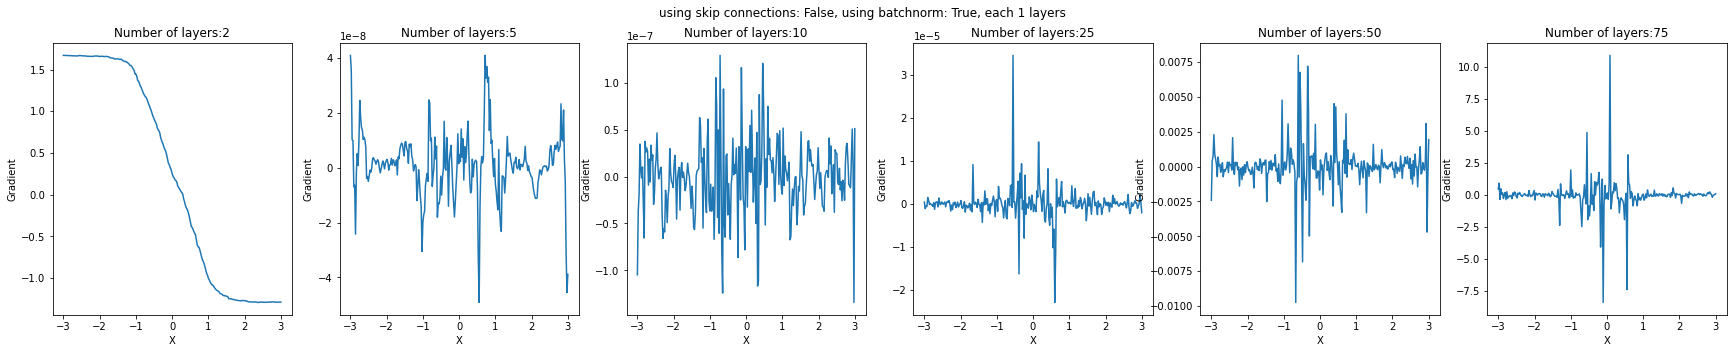

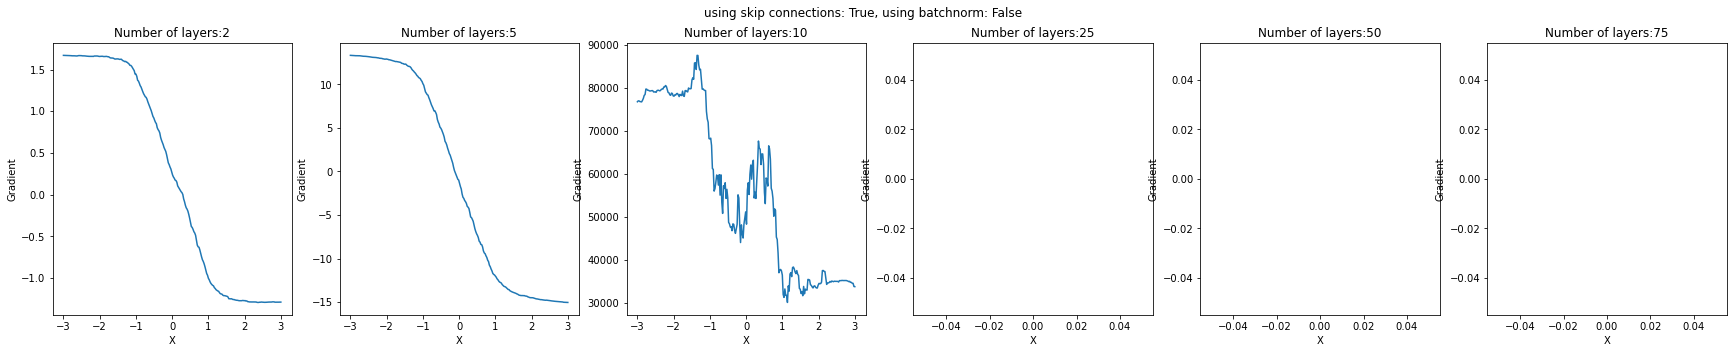

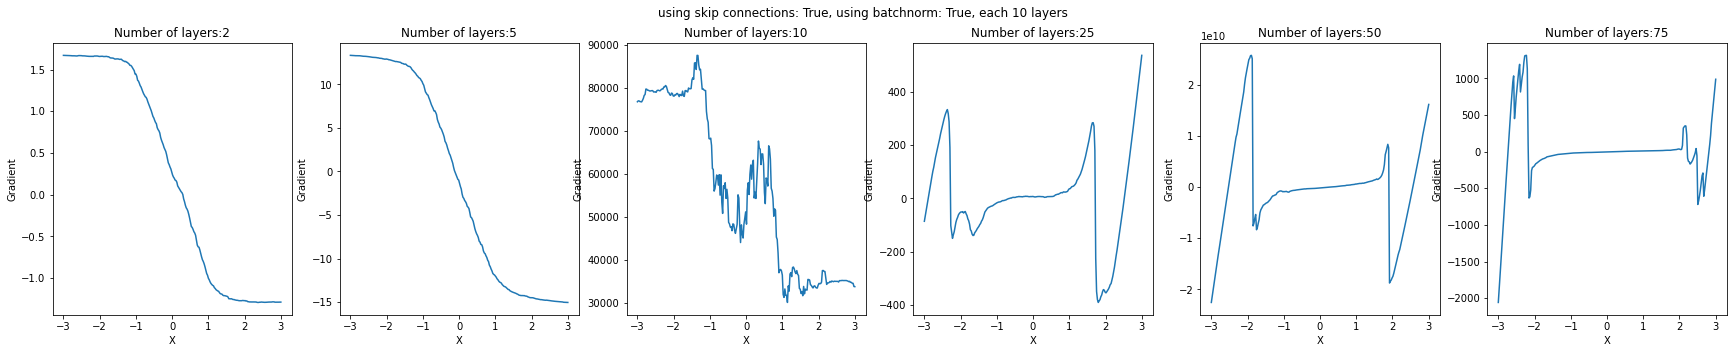

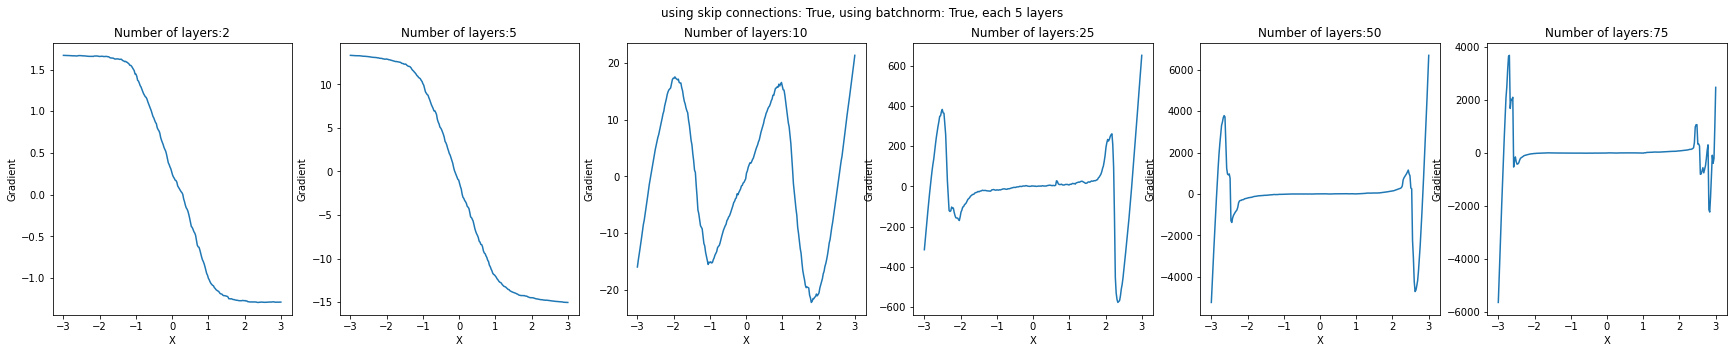

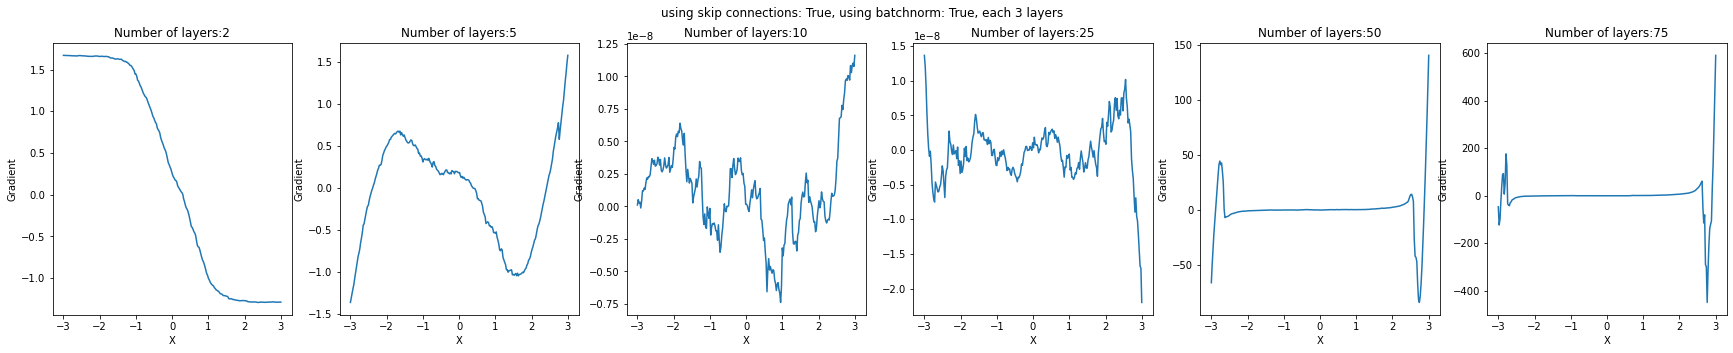

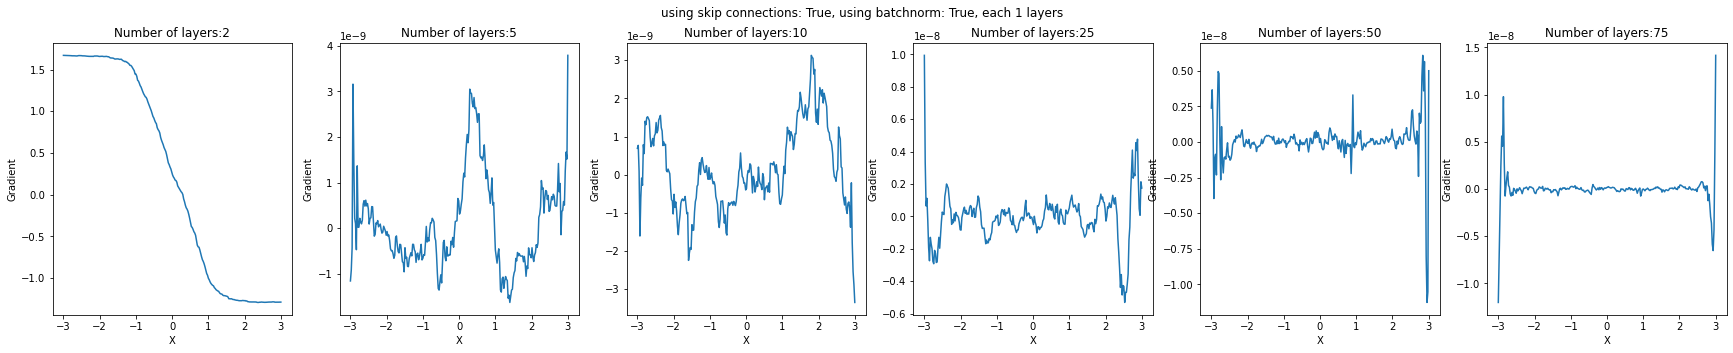

In [4]:
N = 256
X = torch.linspace(-3, 3, N).unsqueeze(1) 
list_depth = [2, 5, 10, 25, 50, 75]
list_frequency = [None, 10, 5, 3, 1]
list_use_skip = [False, True]
n_iter = 30

for use_skip in list_use_skip:
    for batchnorm_frequency in list_frequency:
        
        use_batchnorm_layer = batchnorm_frequency is not None
        
        fig, axs = plt.subplots(ncols=len(list_depth), figsize=(5*len(list_depth), 5))
        fig_title = (
            'using skip connections: ' + str(use_skip)
            + ', using batchnorm: ' + str(use_batchnorm_layer)
        )
        if use_batchnorm_layer:
            fig_title += ", each " + str(batchnorm_frequency) + " layers"
        fig.suptitle(fig_title)
        
        for i, L in enumerate(list_depth):
            
            mean_gradients = compute_mean_gradients(
                X, 
                L = L, 
                use_skip = use_skip, 
                batchnorm_frequency = batchnorm_frequency, 
                n_iter = n_iter)
            
            axs[i] = plot_gradients(axs[i], L, X, mean_gradients)
        
        plt.show()
        

## 3. Effects of residual layers, batchnormalization and depth on overfitting


In [5]:
def load_cifar(train_val_split=0.9, data_path='../data/', preprocessor=None):
    
    # Define preprocessor if not already given
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468),
                                (0.2470, 0.2435, 0.2616))
        ])
    
    # load datasets
    data_train_val = datasets.CIFAR10(
        data_path,       
        train=True,      
        download=True,
        transform=preprocessor)

    data_test = datasets.CIFAR10(
        data_path, 
        train=False,
        download=True,
        transform=preprocessor)

    # train/validation split
    n_train = int(len(data_train_val)*train_val_split)
    n_val =  len(data_train_val) - n_train

    # Add seed so that we get the same dataloaders
    data_train, data_val = random_split(
        data_train_val, 
        [n_train, n_val],
        generator=torch.Generator().manual_seed(123)
    )
    
    # Now define a lighter version of CIFAR10: cifar
    label_map = {0: 0, 2: 1}

    # For each dataset, keep only airplanes and birds
    cifar2_train = [(img, label_map[label]) for img, label in data_train if label in [0, 2]]
    cifar2_val = [(img, label_map[label]) for img, label in data_val if label in [0, 2]]
    cifar2_test = [(img, label_map[label]) for img, label in data_test if label in [0, 2]]

    print('Size of the training dataset: ', len(cifar2_train))
    print('Size of the validation dataset: ', len(cifar2_val))
    print('Size of the test dataset: ', len(cifar2_test))
    
    return (cifar2_train, cifar2_val, cifar2_test)

def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    #model.train() moved inside loop!
    optimizer.zero_grad(set_to_none=True)
    
    n_batch_train = len(train_loader)
    n_batch_val = len(val_loader)
    
    losses_train = []
    losses_val = []
    
    for epoch in range(1, n_epochs + 1):
        
        # Train model and compute training loss
        model.train()
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch_train)
            
        # Compute validation loss
        model.eval()
        # Prevent Pytorch from computing and keeping track of gradients
        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                
                imgs = imgs.to(device=device) 
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                # The backpropagation and update steps have disappeared!
                loss_val += loss.item()
                
        losses_val.append(loss_val / n_batch_val)
            
    return (losses_train, losses_val)

def plot_losses(ax, L, loss_train, loss_val):
    ax.set_title('Number of layers:' + str(L))
    ax.plot(loss_train, label='train')
    ax.plot(loss_val, label='validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()
    return ax

data_train, data_val, data_test = load_cifar()

100.0%

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified
Size of the training dataset:  9017
Size of the validation dataset:  983
Size of the test dataset:  2000


### Experiment

1. Load and preprocess the CIFAR-10 dataset. Split it into 3 datasets: training, validation and test. Take a subset of these datasets by keeping only 2 labels: bird and plane.
1. Modify your residual network so that its input and output layers match the dataset (Now ``n_in=32*32*3``, ``n_out=2``. You can also set ``n_hid`` to ``64`` for example, to reduce computations) 
1. Plot the training loss and the validation loss for different values of depth, ``batchnorm_frequency`` and with or without residual skip. (you can keep the values suggested in the cell below)
1. Comment your results.
1. Select and evaluate the best model among the different values of depth, ``batchnorm_frequency`` and ``use_skip`` used.

Training on device cuda.


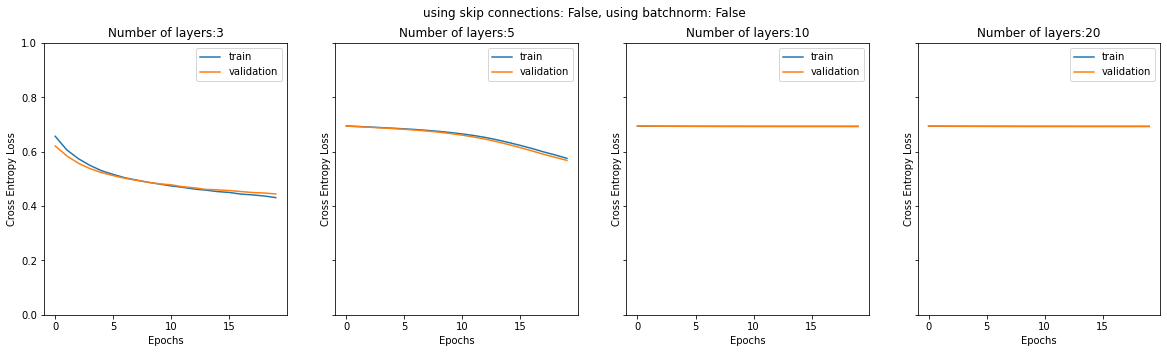

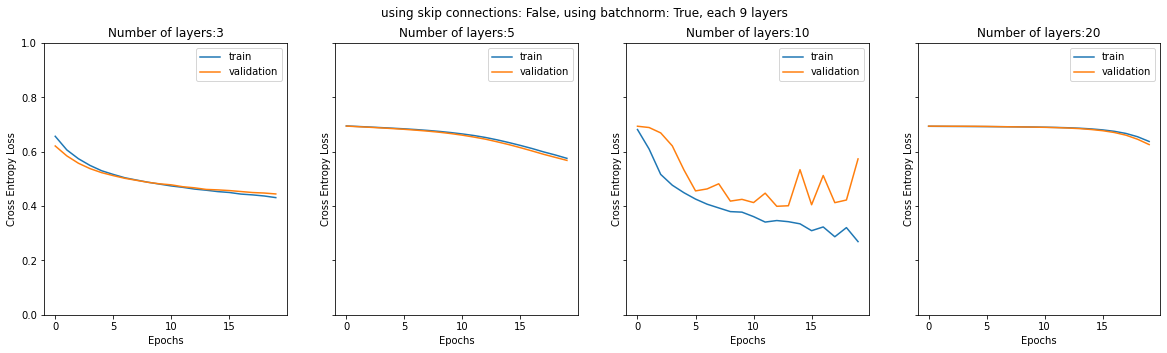

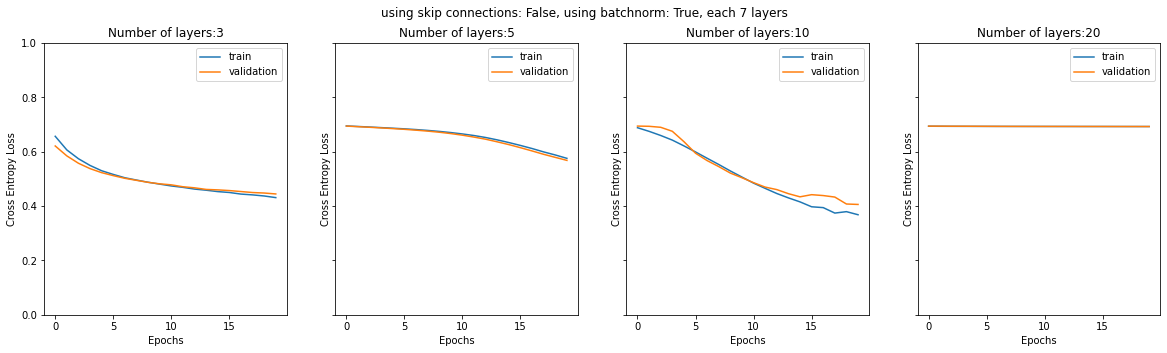

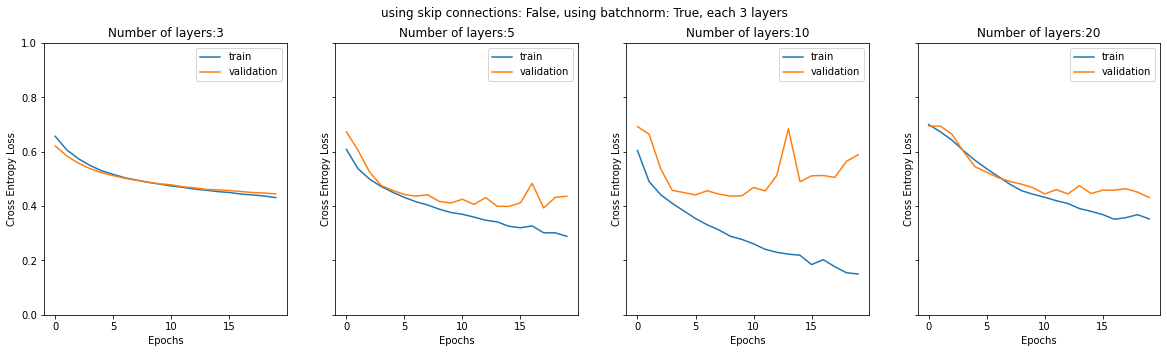

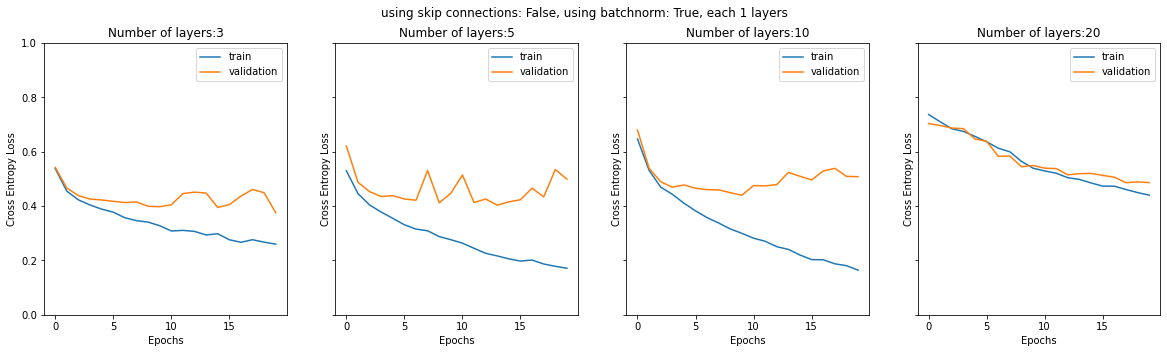

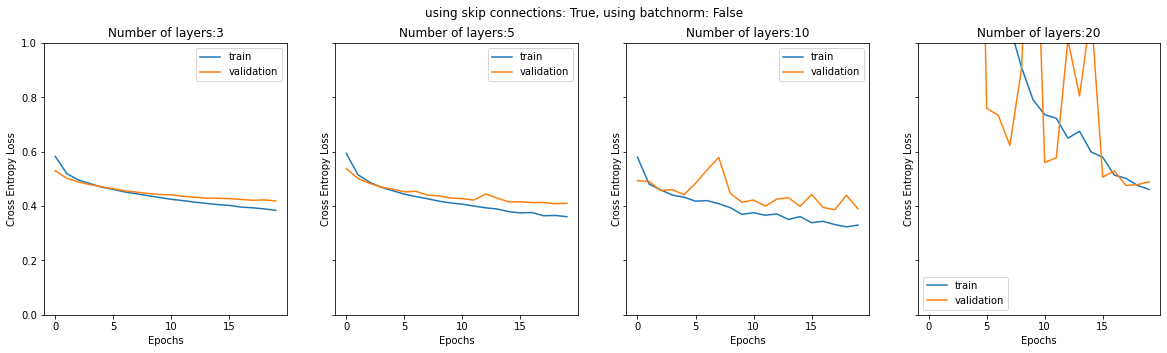

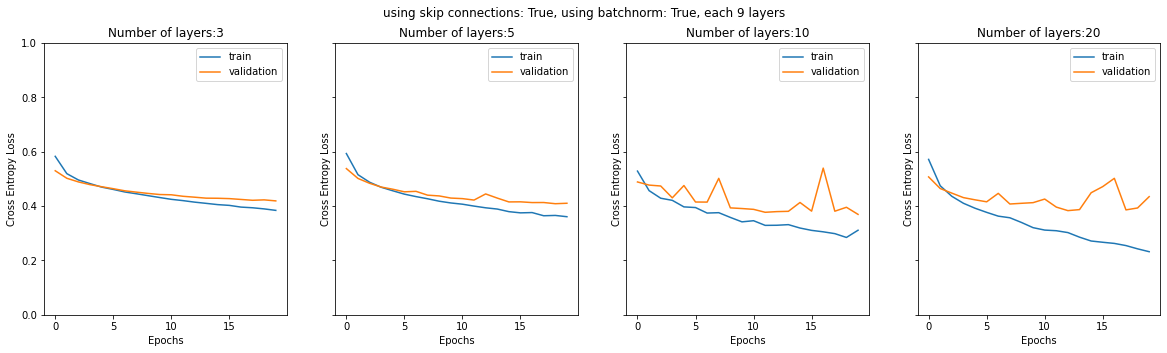

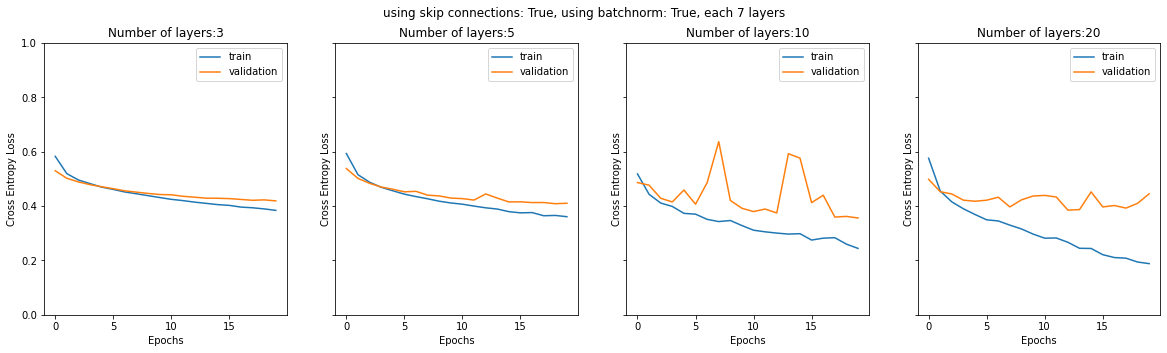

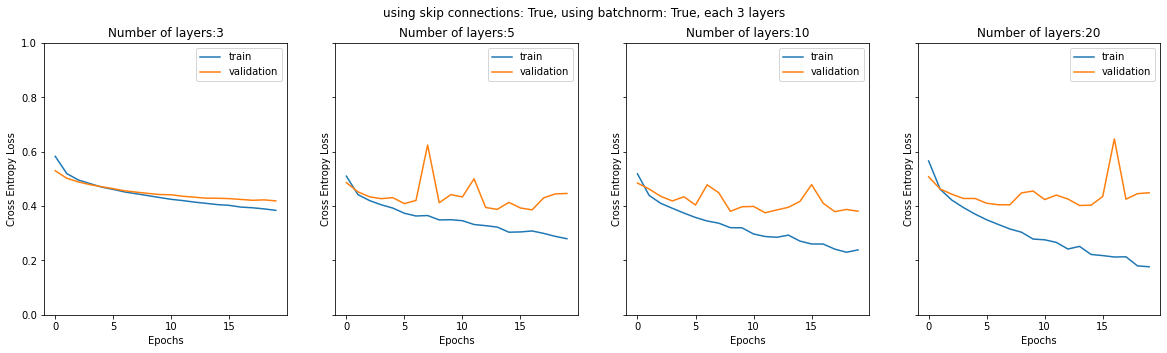

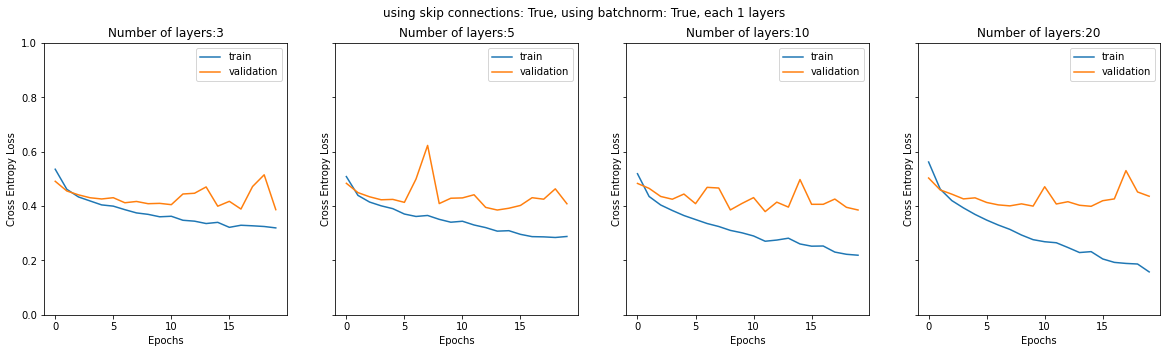

In [6]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

n_epochs = 20
batch_size = 512

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
lr = 0.01
momentum = 0.9
momentum = 0.

models = []
model_names = []
losses_train = []
losses_val = []

list_depth = [3, 5, 10, 20]
list_frequency = [None, 9, 7, 3, 1]
list_use_skip = [False, True]


for use_skip in list_use_skip:
    for batchnorm_frequency in list_frequency:
        
        use_batchnorm_layer = batchnorm_frequency is not None
        
        fig, axs = plt.subplots(ncols=len(list_depth), figsize=(5*len(list_depth), 5), sharey=True)
        fig_title = (
            'using skip connections: ' + str(use_skip)
            + ', using batchnorm: ' + str(use_batchnorm_layer)
        )
        if use_batchnorm_layer:
            fig_title += ", each " + str(batchnorm_frequency) + " layers"
        fig.suptitle(fig_title)
        
        for i, L in enumerate(list_depth):
            
            torch.manual_seed(265)
            model = MyNet(
                n_in = 32*32*3,
                n_out = 2,
                n_hid = 64,
                L = L,
                batchnorm_frequency = batchnorm_frequency,
                use_skip = use_skip,
            ).to(device=device) 
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

            loss_train, loss_val = train(
                n_epochs = n_epochs,
                optimizer = optimizer,
                model = model,
                loss_fn = loss_fn,
                train_loader = train_loader,
                val_loader = val_loader,
            )

            models.append(model)
            model_names.append('L='+str(L)+', use_skip='+str(use_skip)+", batchnorm_frequency="+str(batchnorm_frequency))
            losses_train.append(loss_train)
            losses_val.append(loss_val)
        
            axs[i] = plot_losses(axs[i], L, loss_train, loss_val)
            axs[i].set_ylim(0, 1)
        
        plt.show()

### Model selection

In [7]:
def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    acc =  correct / total
    return acc

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False)

accuracies = []

for model in models:
    accuracies.append(compute_accuracy(model, val_loader))
    
i_best_model = np.argmax(accuracies)
best_model = models[i_best_model]
print("\nThe best model is ", model_names[i_best_model])


print("Training accuracy of the best model: ")
print(compute_accuracy(best_model, train_loader))
print("Validation accuracy of the best model: ")
print(compute_accuracy(best_model, val_loader))


The best model is  L=10, use_skip=True, batchnorm_frequency=7
Training accuracy of the best model: 
0.9187091050238438
Validation accuracy of the best model: 
0.8463886063072228


### Model Evaluation

In [8]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False)

print("Test accuracy of the best model: ")
print(compute_accuracy(best_model, test_loader))

Test accuracy of the best model: 
0.8515
